In [1]:
'''
ring or otherwise manifold attractor for storing motor memories 
'''

'\nring or otherwise manifold attractor for storing motor memories \n'

In [2]:
import sys

# Specify the directory you want to add
custom_path = './..'

# Add the directory to sys.path
if custom_path not in sys.path:
    sys.path.append(custom_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import copy

from dsp_utils import process_segment

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
max_iter = 1000
validate_every = 10
batch_size = 256
n_rnn = 256


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
totorch  = lambda x: torch.tensor(x,dtype=torch.float32,device=device,requires_grad=False)

In [6]:
deg = np.pi/180
arctan2_ = lambda x: np.arctan2(x[:,1],x[:,0]) 
#general rules of the game:
data_params = dict(p_switch = 0.1,
    tmax = 100,
    t_refrac = 2,
    phi_lims = [-180*deg,180*deg],
    sigma_at_input = 1e-5*deg,
    sigma_at_silence = 1e-5*deg,
    )

#1. starting from perfect memory: from (noisy) data learning to retain many angles
#2. exposing to sequence of noisy signals, while continuing learning
#3. autonomous regime: no input at all 

def generate_batch(batch_size=64, prev_theta=None, create_test_batch=None, manual_data=None, a=1., **params):

    x = np.zeros((batch_size,params['tmax'],2))
    y = np.zeros((batch_size,params['tmax'],2))

    if create_test_batch is not None:
        theta = create_test_batch['theta']
        x[:,create_test_batch['times'],:] = np.array([np.sin(theta),np.cos(theta)]).T.reshape(batch_size,1,2)
        return x
        
    if prev_theta is None:
        theta = np.random.uniform(*params['phi_lims'],size=(batch_size))
    else:
        theta = prev_theta

    for t in range(params['tmax']):
        if manual_data is not None:
            mask = manual_data['mask'][t].reshape([batch_size])
            theta = manual_data['theta'][t].reshape([batch_size])
        else:
            theta_upd = np.random.uniform(*params['phi_lims'],size=(batch_size))
            mask = np.random.rand(batch_size) < params['p_switch'] 
            theta = theta*(1-mask) + theta_upd*mask
        #instances that are switching are the only that get input
        x[:,t,:] = a*np.array([np.cos(theta),np.sin(theta)]).T * mask[:,None]
        x[:,t,:] += np.random.randn(batch_size,2) * params['sigma_at_input'] * mask[:,None] 
        x[:,t,:] += np.random.randn(batch_size,2) * params['sigma_at_silence'] * (1-mask)[:,None]
        #all the instances must generate output
        y[:,t,:] = a*np.array([np.cos(theta),np.sin(theta)]).T

    return x,y,theta

# x_test,y_test,theta = generate_batch(batch_size=64,**data_params)
x_test = generate_batch(batch_size=batch_size,create_test_batch=dict(times=[1,6,11], theta = np.linspace(-3,3,batch_size)),**data_params)
x_test = torch.tensor(x_test,dtype=torch.float32,device=device,requires_grad=False)


class RNN(nn.Module):
    def __init__(self,d_in,d_out,n_pre_mlp,n_post_mlp,n_rnn):
        super(RNN,self).__init__()
        
        self.pre_mlp = nn.Sequential(*[nn.Linear(d_in,n) for n in n_pre_mlp])
        self.rnn = nn.RNN(n_pre_mlp[-1],n_rnn[0],batch_first=True)
        self.post_mlp = nn.Sequential(*[nn.Linear(n_rnn[-1],n) for n in n_post_mlp])
        self.out = nn.Linear(n_post_mlp[-1],d_out)
        
    def forward(self,x,s):
        x = self.pre_mlp(x)
        x,s = self.rnn(x,s)
        x = self.post_mlp(x)
        x = self.out(x)
        return x,s
    

In [7]:
import torch

class RNNTrainer:
    def __init__(self, model, optimizer, criterion):
        """
        Initializes the RNNTrainer.

        Args:
            model (torch.nn.Module): The RNN model.
            optimizer (torch.optim.Optimizer): The optimizer.
            criterion (torch.nn.Module): The loss function.
        """
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train_step(self, x, y, s):
        """
        Performs a single RNN training step.

        Args:
            x (torch.Tensor): Input tensor.
            y (torch.Tensor): Target tensor.
            s (torch.Tensor): Hidden state tensor.

        Returns:
            loss_value (float): The loss value of the current step.
            new_s (torch.Tensor): The detached hidden state for the next step.
        """
        self.model.train()

        self.optimizer.zero_grad()
        out, s = self.model(x, s)
        loss = self.criterion(out, y)
        loss.backward()
        self.optimizer.step()
        s = s.detach()
        return loss.item(), s, out

    def eval_step(self, x, y, s):
        """
        Performs a single RNN eval step.

        Args:
            x (torch.Tensor): Input tensor.
            y (torch.Tensor): Target tensor.
            s (torch.Tensor): Hidden state tensor.

        Returns:
            loss_value (float): The loss value of the current step.
            new_s (torch.Tensor): The detached hidden state for the next step.
        """
        self.model.eval()
        out, s = self.model(x, s)
        loss = self.criterion(out, y)

        s = s.detach()
        self.model.train()
        return loss.item(), s, out

In [8]:
criterion = nn.MSELoss()

model = RNN(d_in=2,d_out=2, n_pre_mlp=[256], n_post_mlp=[256], n_rnn=[n_rnn])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
model.to(device)

RNN(
  (pre_mlp): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
  )
  (rnn): RNN(256, 256, batch_first=True)
  (post_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=2, bias=True)
)

In [9]:
rnn_trainer = RNNTrainer(model, optimizer, criterion)

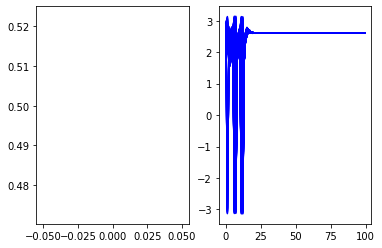

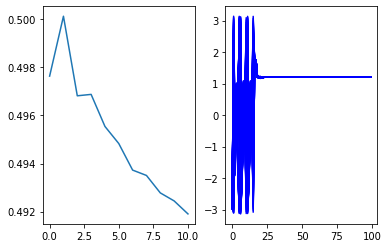

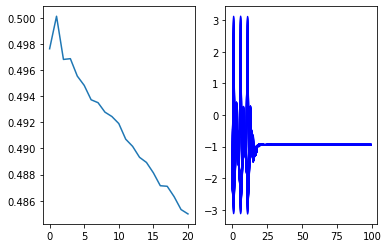

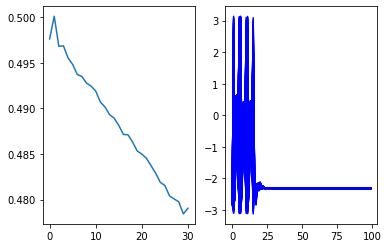

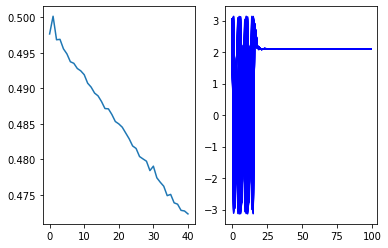

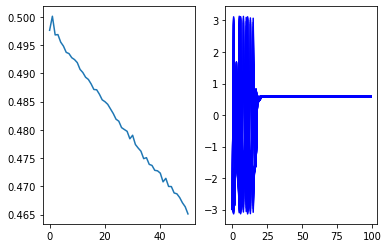

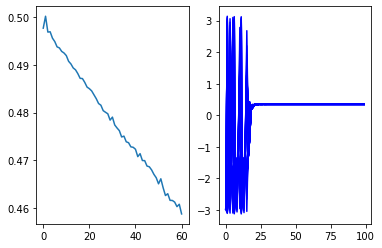

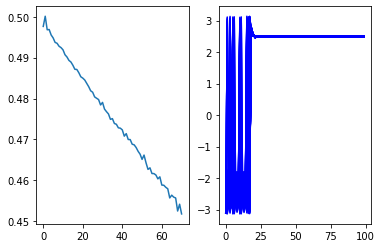

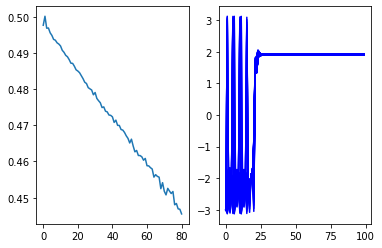

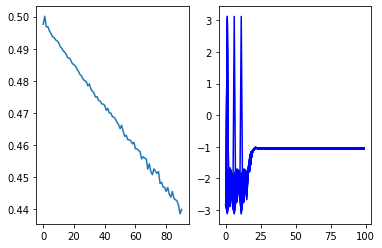

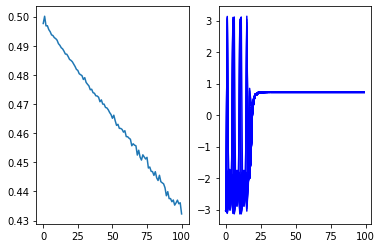

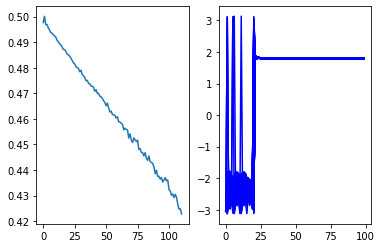

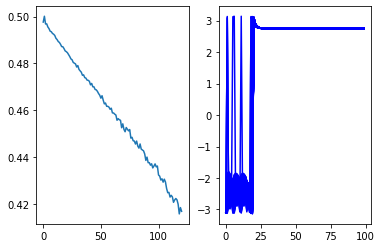

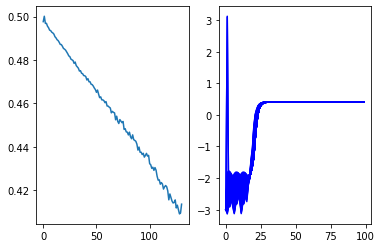

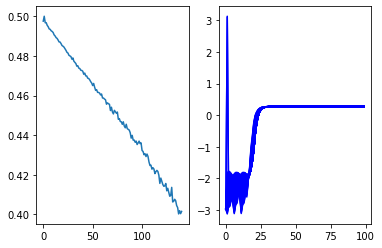

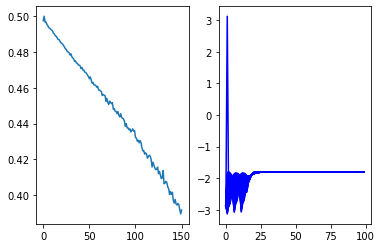

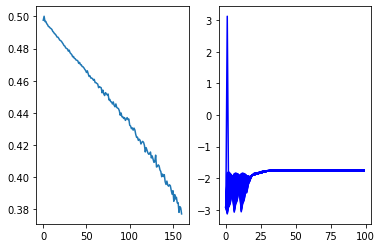

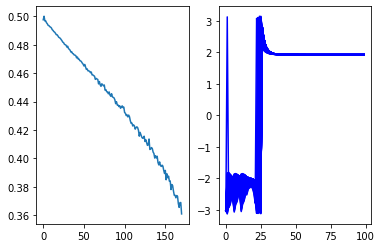

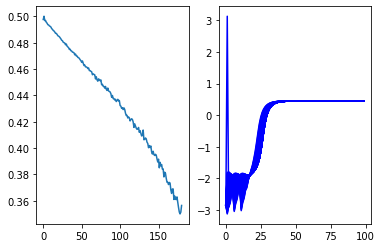

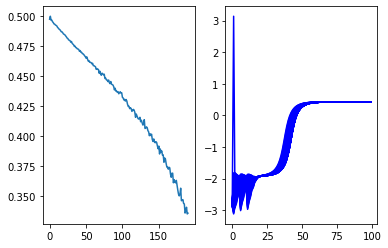

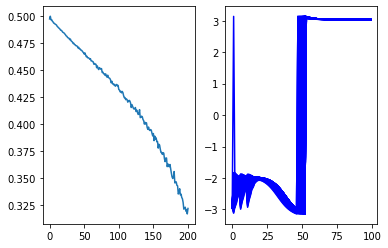

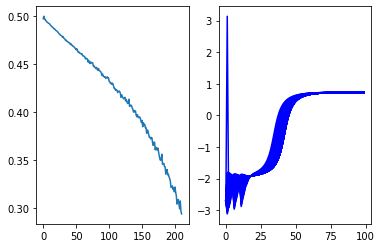

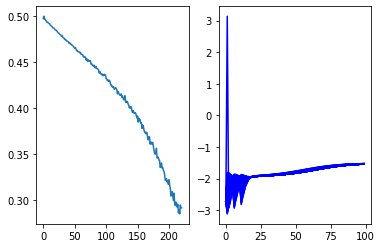

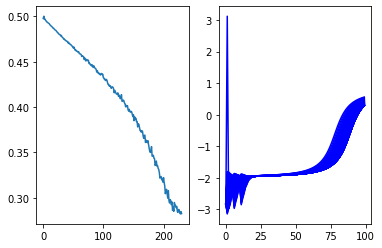

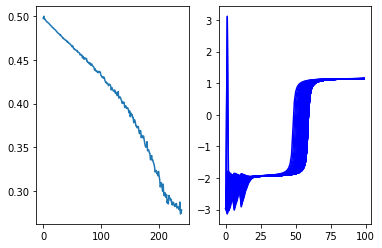

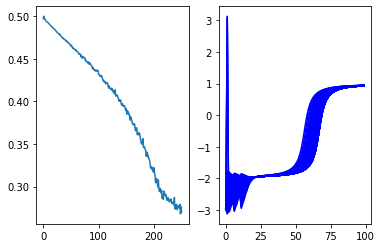

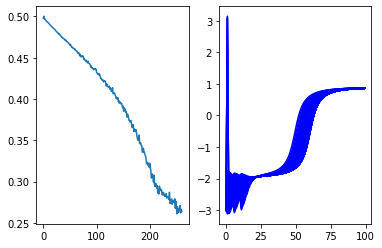

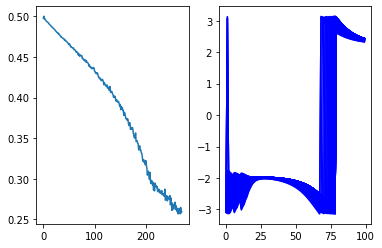

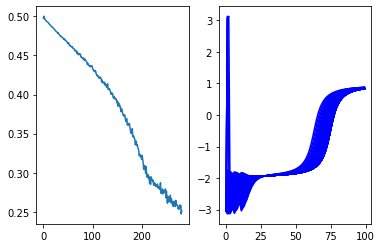

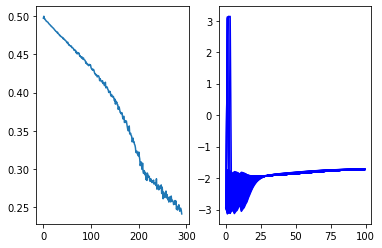

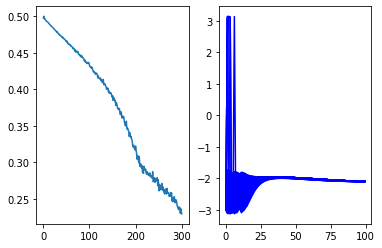

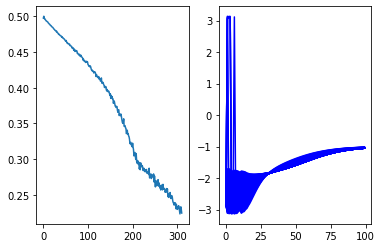

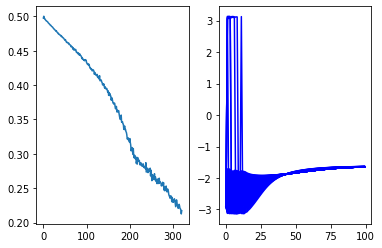

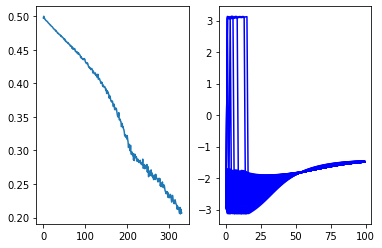

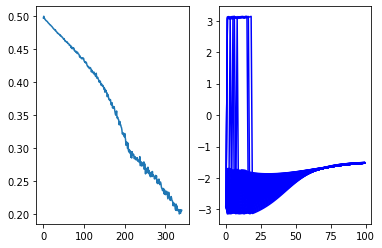

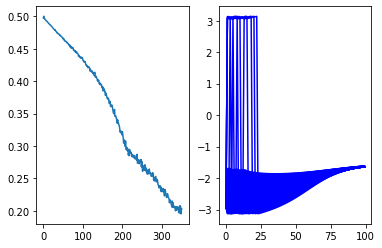

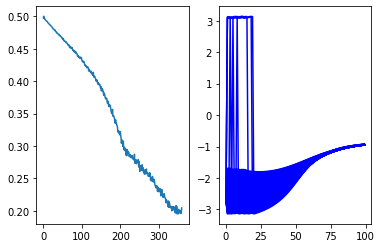

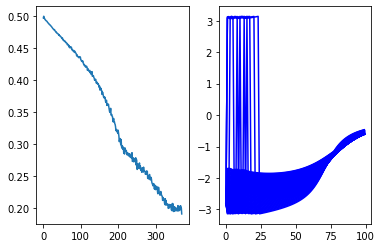

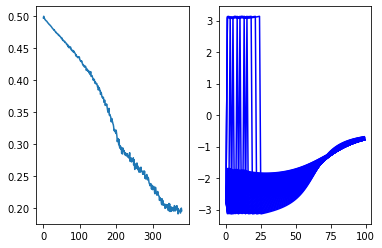

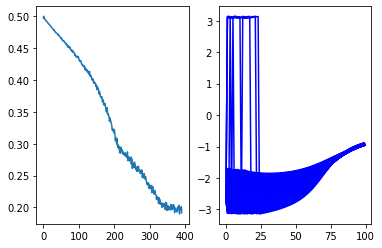

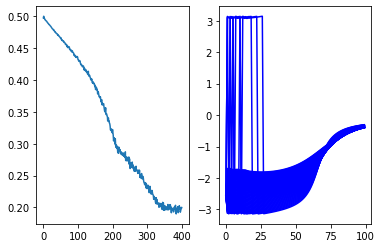

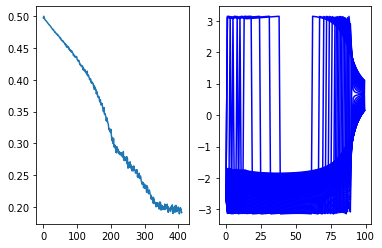

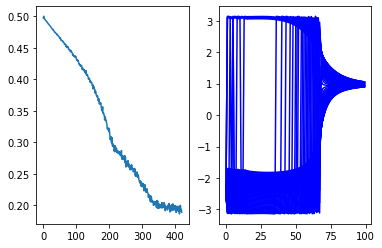

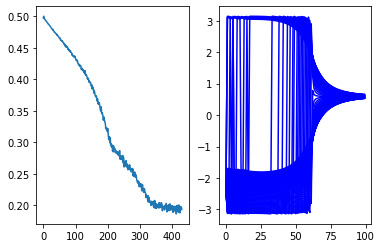

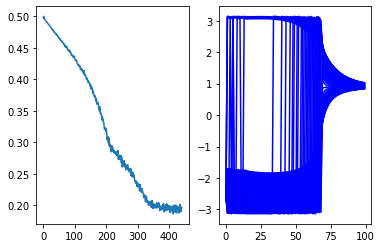

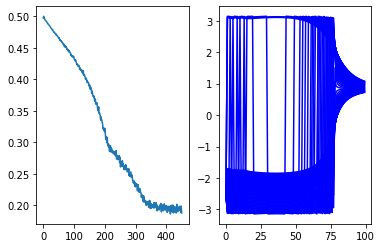

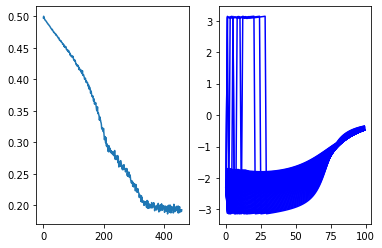

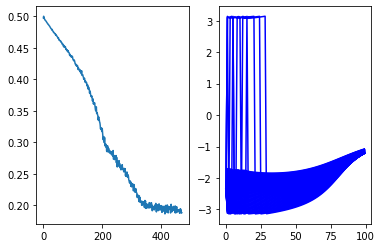

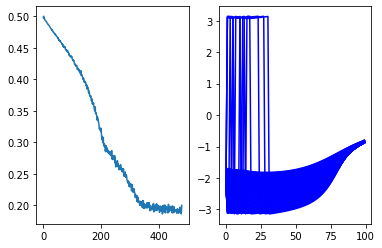

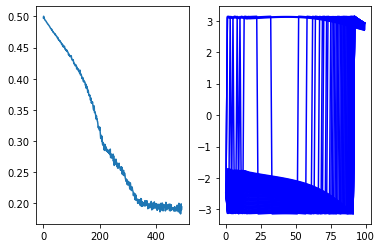

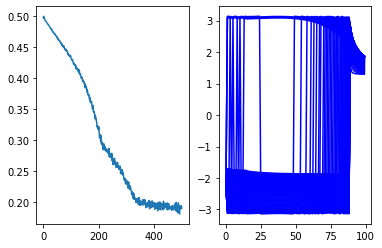

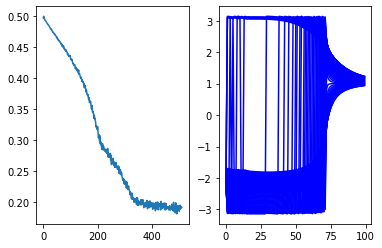

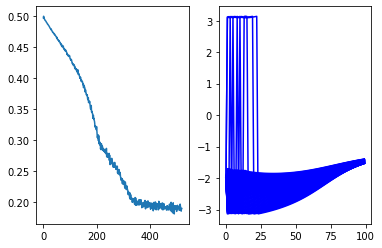

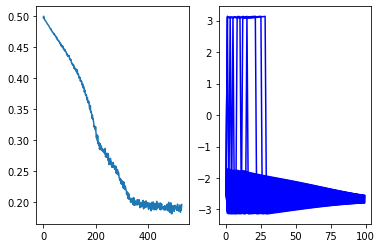

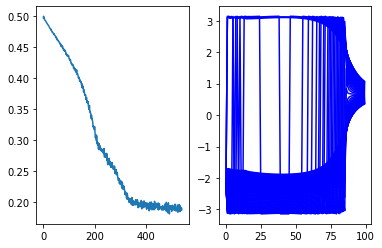

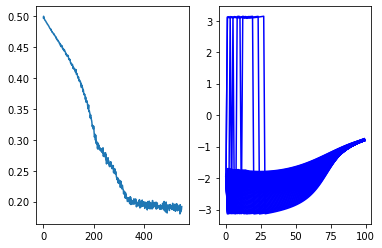

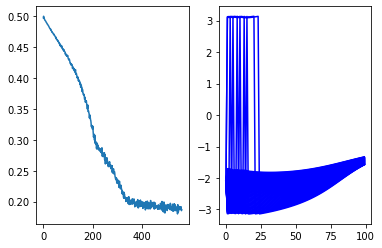

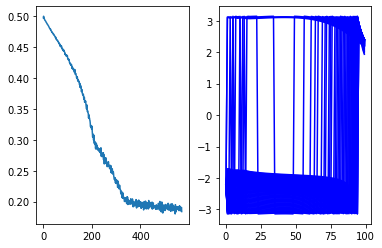

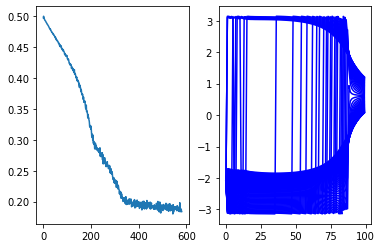

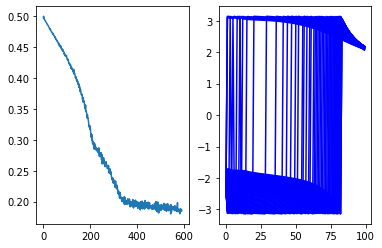

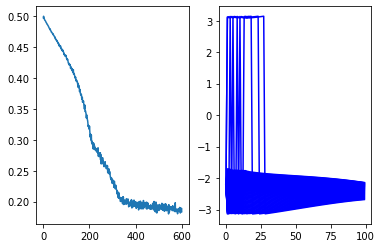

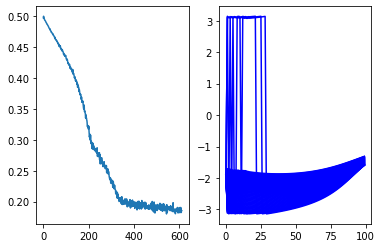

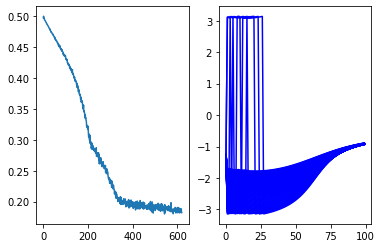

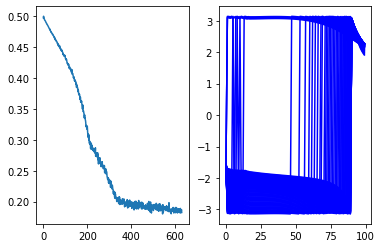

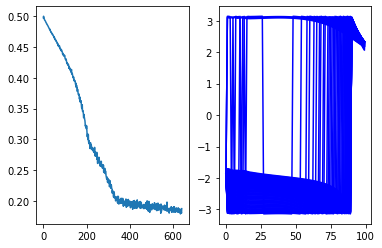

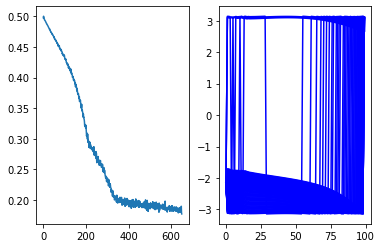

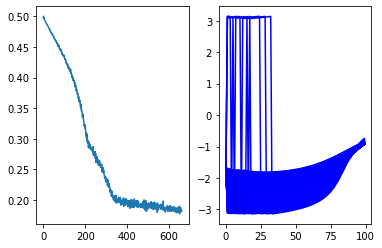

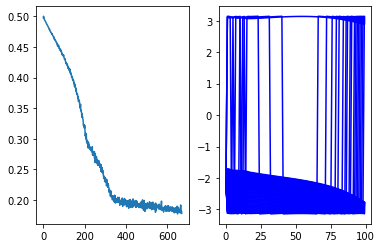

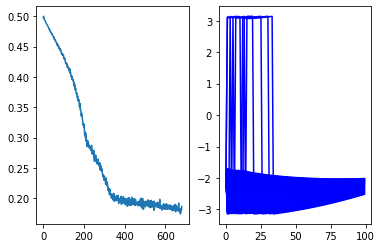

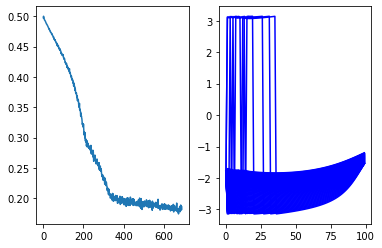

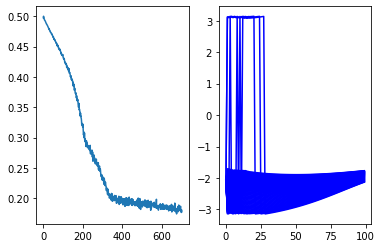

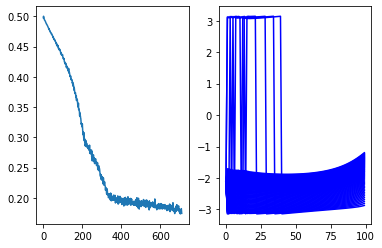

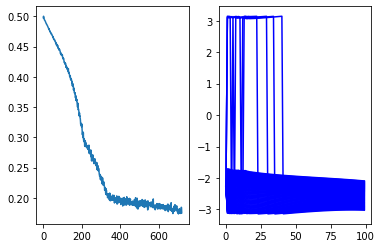

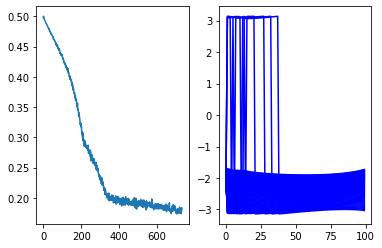

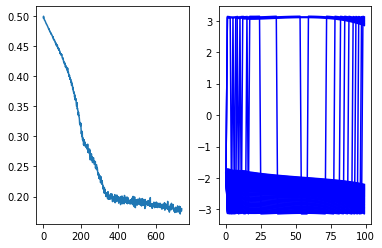

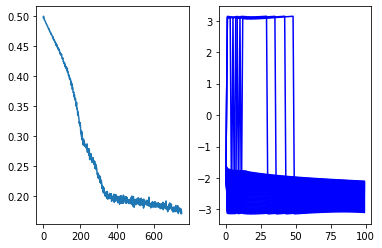

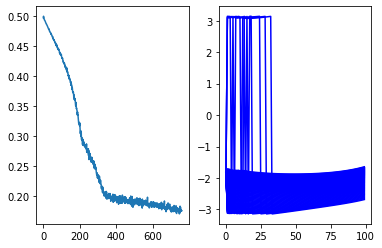

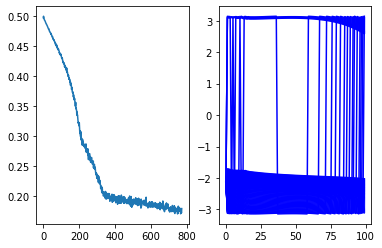

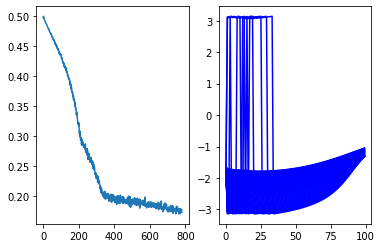

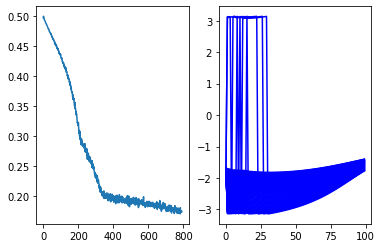

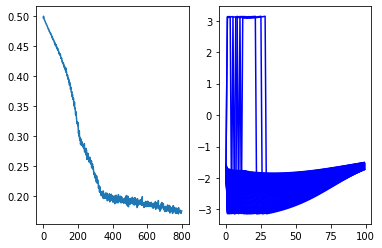

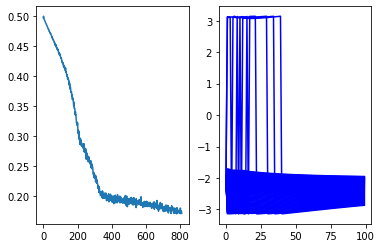

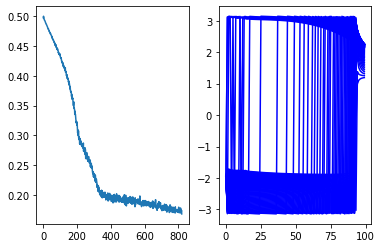

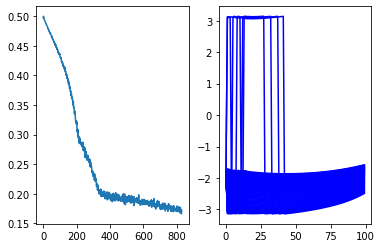

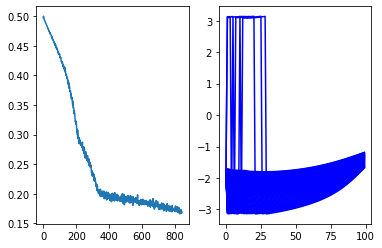

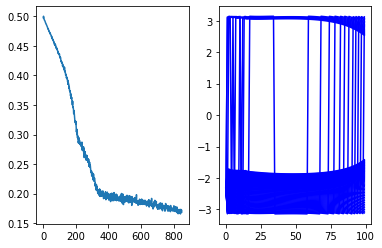

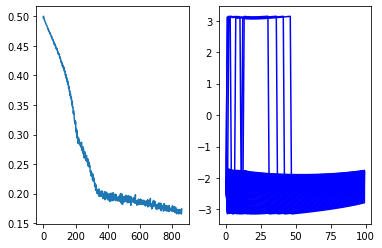

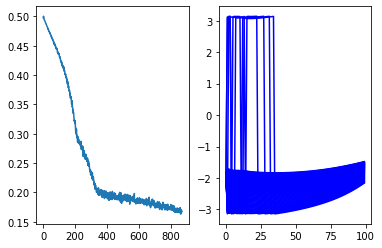

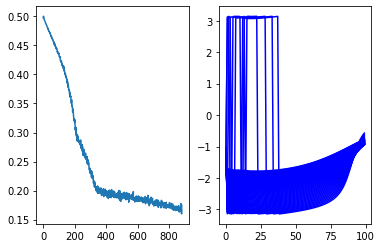

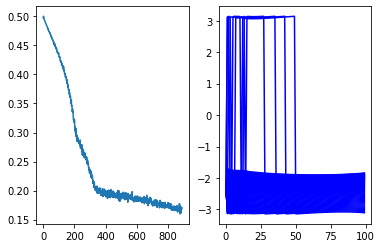

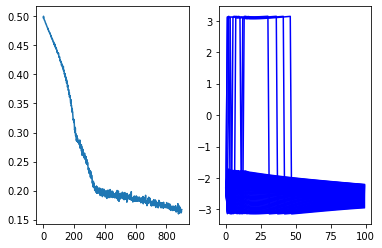

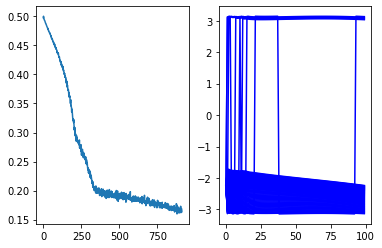

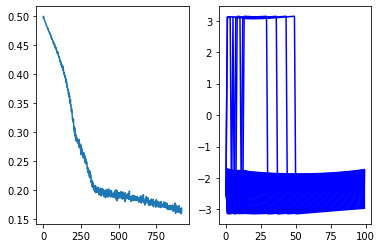

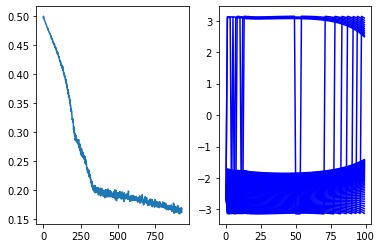

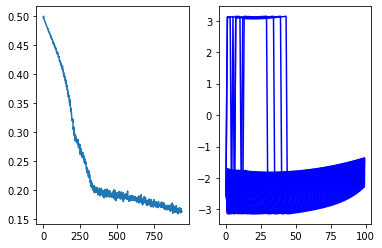

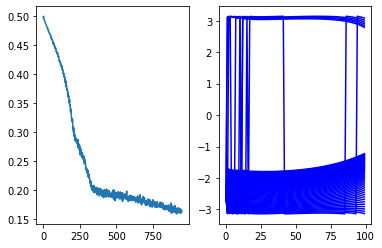

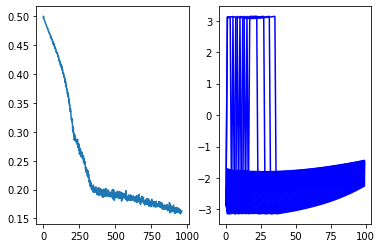

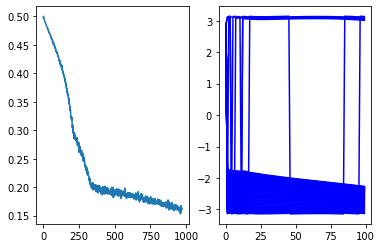

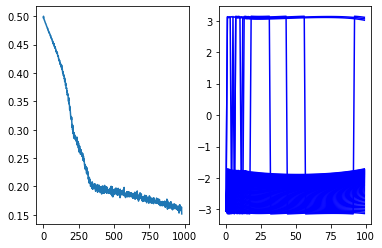

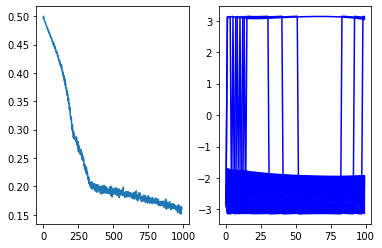

In [10]:
theta = None
losses = []

s = torch.zeros(1,batch_size,n_rnn,device=device,requires_grad=False)
s0 = torch.zeros(1,batch_size,n_rnn,device=device,requires_grad=False)

for i in range(max_iter):
    
    x,y,theta = generate_batch(batch_size=batch_size,prev_theta=theta,**data_params)
    x = torch.tensor(x,dtype=torch.float32,device=device,requires_grad=False)
    y = torch.tensor(y,dtype=torch.float32,device=device,requires_grad=False)
    loss,s,out = rnn_trainer.train_step(x,y,s)
    
    losses.append(loss)

    if i % validate_every == 0:
        model.eval()

        val_out, _ = model(x_test,s0)
        y_test = val_out.detach().cpu().numpy()

        plt.subplot(1,2,1)
        plt.plot(losses)
        plt.subplot(1,2,2)
        for i in range(64):
            plt.plot(arctan2_(y_test[i]),'b')
            
        plt.show()

        model.train()
    
        

In [11]:
baseline_state_dict = copy.deepcopy(model.state_dict())


In [12]:
def play_piecewise_paradigm(piecewise_data=None, s=None, idle_steps=10, batch_size=1, **gen_params):
    outs = []
    for this_data in piecewise_data:
        if np.isnan(this_data[0]):
            gen_params['a']=0
            this_data = (0,this_data[1])
            channel_flag = True
            step_method = rnn_trainer.eval_step
        else:
            channel_flag = False
            step_method = rnn_trainer.train_step

        theta = process_segment(this_data)
        theta = np.repeat(theta,idle_steps+1)
        mask = np.zeros_like(theta)
        mask[0::idle_steps+1] = 1
        x,y,_ = generate_batch(batch_size=batch_size,
                               prev_theta=None, 
                               manual_data=dict(theta=theta,mask=mask),
                               **{**gen_params, 'tmax': this_data[1]*(idle_steps+1)})
        x = totorch(x)
        y = totorch(x)
        _, s, out = step_method(x,y,s)
        outs.append(out.detach().cpu().numpy())
    return np.concatenate(outs,axis=1)        
        
        
    

In [13]:
def visualize_test_batch():
    model.eval()
    val_out, _ = model(x_test,s0)
    y_test = val_out.detach().cpu().numpy()
    for i in range(64):
        plt.plot(arctan2_(y_test[i]),'b')

In [14]:
P=30.*deg

paradigms = [[(0.0,2)],
                [(0.0,300)],
                [(0.0,100),(P,50),(-P,10),(np.nan,100)],
            [(0.0,100),(P,50),(-P,10),(P,2),(np.nan,100)]]

/tmp/ipykernel_3245/504879398.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  totorch  = lambda x: torch.tensor(x,dtype=torch.float32,device=device,requires_grad=False)


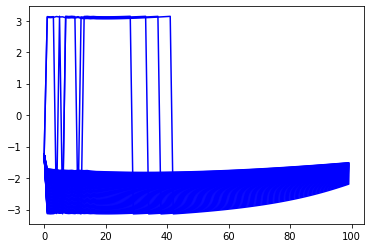

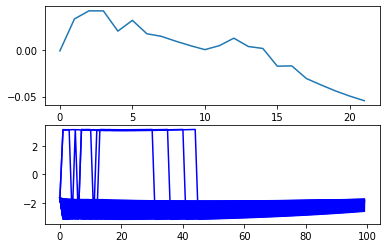

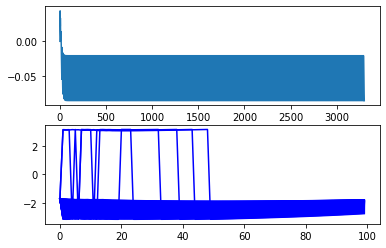

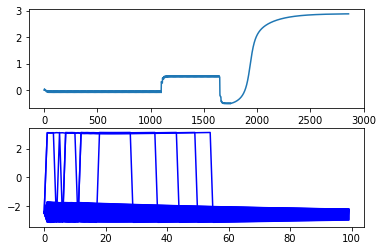

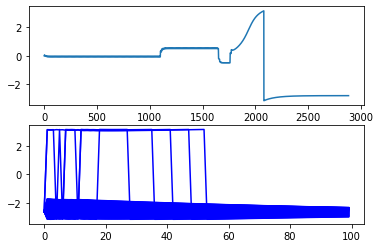

In [15]:
visualize_test_batch()

for paradigm in paradigms:
    plt.figure()
    model.load_state_dict(copy.deepcopy(baseline_state_dict))
    optimizer_prime = torch.optim.SGD(model.parameters(),lr=1e-4)
    
    rnn_trainer.optimizer = optimizer_prime
    outs = play_piecewise_paradigm(paradigm,**data_params)
    plt.subplot(2,1,1)
    plt.plot(arctan2_(outs.squeeze()))
    plt.subplot(2,1,2)
    visualize_test_batch()
    

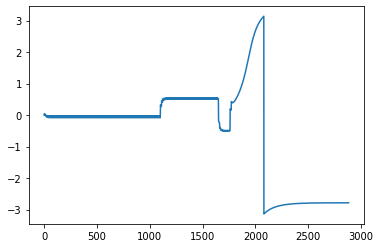

In [16]:
plt.plot(arctan2_(outs.squeeze())) 

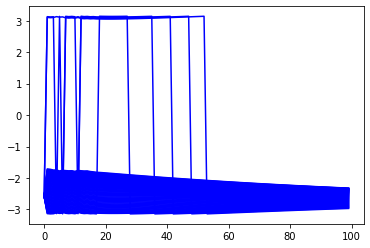

In [17]:
        model.eval()
        val_out, _ = model(x_test,s0)
        y_test = val_out.detach().cpu().numpy()
        for i in range(64):
            plt.plot(arctan2_(y_test[i]),'b')

In [18]:
play_piecewise_paradigm

<function __main__.play_piecewise_paradigm(piecewise_data=None, s=None, idle_steps=10, batch_size=1, **gen_params)>

In [19]:
y_test = val_out[0].detach().cpu().numpy()
x_test_= x_test.detach().cpu().numpy()

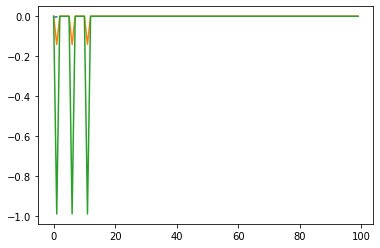

In [20]:
plt.plot(y_test[0])
plt.plot(x_test_[0])

In [21]:
for i in range(10):
    plt.figure()
    plt.plot(arctan2_(y_test[i]))
    plt.plot(arctan2_(x_test_[i])*np.linalg.norm(x_test_[i],axis=-1),'*')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(np.linalg.norm(x_test_[0],axis=-1))

In [ ]:
uu = generate_batch(create_test_batch=dict(times=[1,6,11], theta = np.linspace(-3,3,batch_size)),**data_params)

In [ ]:
uu_ = torch.tensor(uu,dtype=torch.float32,device=device,requires_grad=False)

In [ ]:
outs = model(uu_,s0)

In [ ]:
outs_ = outs[0].detach().cpu().numpy()

In [ ]:
for i in range(64):
#     plt.figure()
    plt.plot(arctan2_(outs_[i]),'b')

In [ ]:
for i in range(64):
    plt.plot(i,arctan2_(uu[i])[5],'x')

In [ ]:
loss

In [ ]:
type(loss.item())

In [1]:
uu=6